# CONUS 404 diagnostic plots

### Data Access

- This notebook illustrates how to make diagnostic plots using the CONUS 404 dataset hosted on NCAR's glade storage.
- https://rda.ucar.edu/datasets/d559000/
- This data is open access and can be accessed via 3 protocols
  1) posix (if you have access to NCAR's HPC systems: Casper or Derecho)
  2) HTTPS
  3) OSDF using intake-ESM catalogs.
- Learn about intake-ESM catalogs: https://intake-esm.readthedocs.io/en/stable/ 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import intake
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# import fsspec.implementations.http as fshttp
# from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
# Catalog URLs
cat_url     = '/glade/campaign/collections/rda/data/d559000/catalogs/d559000_catalog.json' # POSIX access on NCAR
# cat_url     = 'https://data.rda.ucar.edu/d559000/catalogs/d559000_catalog-http.json' # HTTPS access
# cat_url     = 'https://data-osdf.rda.ucar.edu/ncar/rda/d559000/catalogs/d559000_catalog-osdf.json' #OSDF access
print(cat_url)

/glade/campaign/collections/rda/data/d559000/catalogs/d559000_catalog.json


In [5]:
# Get your scratch folder
scratch = os.environ.get("SCRATCH") or getuser()
print(scratch)

/glade/derecho/scratch/harshah


## Create a PBS cluster

In [6]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'wcrp-hackathon25',
    account= 'UCIS0005',
    cores = 1,
    memory = '10GiB',
    processes = 1,
    local_directory = scratch,
    log_directory = scratch,
    resource_spec = 'select=1:ncpus=1:mem=10GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

client = Client(cluster)

In [7]:
# Scale the cluster and display cluster dashboard URL
n_workers = 5
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(7969ad9b, 'tcp://128.117.208.95:44601', workers=5, threads=5, memory=50.00 GiB)

## Load CONUS 404 data from RDA using an intake catalog

In [8]:
col = intake.open_esm_datastore(cat_url)
col

,unique
path,79
variable,206
format,1
short_name,206
long_name,118
units,32
start_time,41
end_time,41
level,0
level_units,0


- col.df turns the catalog object into a pandas dataframe!
- (Actually, it accesses the dataframe attribute of the catalog)

In [9]:
col.df

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/rda/data/d559000/k...,ACDEWC,reference,ACDEWC,"Accumulated canopy dew rate, accumulated over ...",mm,1979-10-01,1980-09-30 23:00:00,NaN,NaN,0 days 01:00:00
1,/glade/campaign/collections/rda/data/d559000/k...,ACDRIPR,reference,ACDRIPR,"Accumulated canopy precipitation drip rate, ac...",mm,1979-10-01,1980-09-30 23:00:00,NaN,NaN,0 days 01:00:00
2,/glade/campaign/collections/rda/data/d559000/k...,ACDRIPS,reference,ACDRIPS,"Accumulated canopy snow drip rate, accumulated...",mm,1979-10-01,1980-09-30 23:00:00,NaN,NaN,0 days 01:00:00
3,/glade/campaign/collections/rda/data/d559000/k...,ACECAN,reference,ACECAN,Accumulated net evaporation of canopy water (e...,mm,1979-10-01,1980-09-30 23:00:00,NaN,NaN,0 days 01:00:00
4,/glade/campaign/collections/rda/data/d559000/k...,ACEDIR,reference,ACEDIR,Accumulated net soil evaporation or snowpack s...,mm,1979-10-01,1980-09-30 23:00:00,NaN,NaN,0 days 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...
8574,/glade/campaign/collections/rda/data/d559000/k...,V,reference,V,NaN,m s-1,2020-10-01,2021-09-30 23:00:00,NaN,NaN,0 days 01:00:00
8575,/glade/campaign/collections/rda/data/d559000/k...,W,reference,W,NaN,m s-1,2020-10-01,2021-09-30 23:00:00,NaN,NaN,0 days 01:00:00
8576,/glade/campaign/collections/rda/data/d559000/k...,Z,reference,Z,NaN,m2 s-2,2020-10-01,2021-09-30 23:00:00,NaN,NaN,0 days 01:00:00
8577,/glade/campaign/collections/rda/data/d559000/k...,ilev,reference,ilev,vertical stagger levels,Dimensionless,2020-10-01,2021-09-30 23:00:00,NaN,NaN,0 days 01:00:00


## Select data and plot

#### What if you don't know the variable names ?
- Use pandas logic to print out the short_name and long_name

In [10]:
col.df[['variable','long_name']]

,variable,long_name
0,ACDEWC,"Accumulated canopy dew rate, accumulated over ..."
1,ACDRIPR,"Accumulated canopy precipitation drip rate, ac..."
2,ACDRIPS,"Accumulated canopy snow drip rate, accumulated..."
3,ACECAN,Accumulated net evaporation of canopy water (e...
4,ACEDIR,Accumulated net soil evaporation or snowpack s...
...,...,...
8574,V,NaN
8575,W,NaN
8576,Z,NaN
8577,ilev,vertical stagger levels


- We notice that long_name is not available for some variables like 'V'
- In such cases, please look at the wrfout_datadictionary file on this page https://rda.ucar.edu/datasets/d559000/documentation/#

### Temperature
- Plot temperature for a random date

In [11]:
cat_temp = col.search(variable='T2')
cat_temp.df.head()

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1979-10-01,1980-09-30 23:00:00,NaN,NaN,0 days 01:00:00
1,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1980-10-01,1981-09-30 23:00:00,NaN,NaN,0 days 01:00:00
2,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1981-10-01,1982-09-30 23:00:00,NaN,NaN,0 days 01:00:00
3,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1982-10-01,1983-09-30 23:00:00,NaN,NaN,0 days 01:00:00
4,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1983-10-01,1984-09-30 23:00:00,NaN,NaN,0 days 01:00:00


- The data is organized in (virtual) zarr stores with one water year's worth of data in one file
- Select a year. This is done by selcting the start time to be Oct 1 of that year or the end time to be Sep 30 of the same year
- This also means that if you want to request data for other days, say Jan 1 for the year YYYY, you first have to load the data for one year i.e., YYYY and then select the data for that particular day. This example is discussed below.


In [12]:
date = "2020-10-01"
# year = "2021"
cat_temp_subset = cat_temp.search(start_time = date)
cat_temp_subset

,unique
path,1
variable,1
format,1
short_name,1
long_name,0
units,1
start_time,1
end_time,1
level,0
level_units,0


### Load data into xarray

In [13]:
# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets = cat_temp_subset.to_dataset_dict(zarr_kwargs={"consolidated": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'



Dataset dictionary keys:
 dict_keys(['T2.T2'])


In [14]:
# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
# store_name = dataset_key + ".zarr"
print(dsets.keys())
ds = dsets[dataset_key]
ds = ds.T2
ds

dict_keys(['T2.T2'])


<xarray.DataArray 'T2' (Time: 8760, south_north: 1015, west_east: 1367)> Size: 49GB
dask.array<open_dataset-T2, shape=(8760, 1015, 1367), dtype=float32, chunksize=(1, 882, 1188), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 70kB 2020-10-01 ... 2021-09-30T23:00:00
    XLAT     (Time, south_north, west_east) float32 49GB dask.array<chunksize=(1, 882, 1188), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 49GB dask.array<chunksize=(1, 882, 1188), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] 70kB dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  TEMP at 2 M
    stagger:       
    units:        K

CPU times: user 437 ms, sys: 322 ms, total: 759 ms
Wall time: 2.04 s


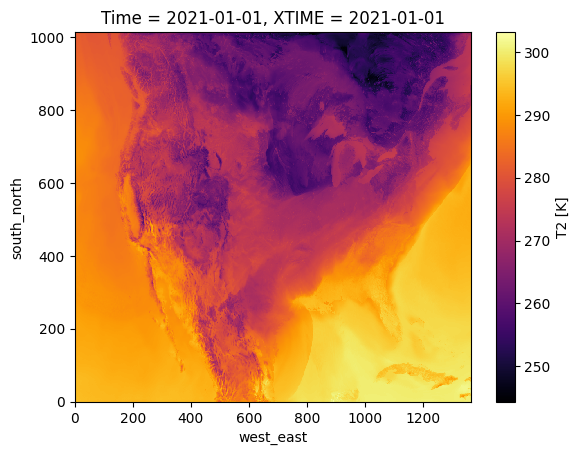

In [17]:
%%time
desired_time = "2021-01-01T00"
ds.sel(Time=desired_time,method='nearest').plot(cmap='inferno')

In [16]:
cluster.close()